<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Search Engine

by Fabian Märki

## Summary
The aim of this notebook is to build a Search Engine based on TF-IDF.

## Links
- [Build your semantic document search engine with TF-IDF and Google-USE](https://medium.com/analytics-vidhya/build-your-semantic-document-search-engine-with-tf-idf-and-google-use-c836bf5f27fb)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2021_HS_CAS_NLP_LAB_Notebooks/blob/master/XX_a_Search_Engine.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.2.13,<0.3.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe


import pandas as pd
import numpy as np

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.11.0-40-generic
Python version: 3.6.9
Tensorflow version: 2.5.1
GPU is available


Download data and load it into a pandas dataframe.

In [3]:
%%time
download("https://drive.google.com/uc?id=17nFv7PKC6YJttZT4D1txk4CCUgduq3pc", "data/german_doctor_reviews_original.parq")
data = load_dataframe("data/german_doctor_reviews_original.parq")
data.shape

CPU times: user 738 ms, sys: 185 ms, total: 923 ms
Wall time: 939 ms


(357899, 2)

In [4]:
data.head(3)

,text_original,rating
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0


Check if notebook runs on colab and reduce model size (RAM is the limiting factor on Colab)

In [5]:
from fhnw.nlp.utils.colab import runs_on_colab

if runs_on_colab():
    data = data.head(100000)

  
We can use [scikit-learn's](https://scikit-learn.org/stable) [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) to create a vocabulary from the text and compute the Term Frequency - Inverse Document Frequency (TF-IDF). 
The result is a sparse matrix representation of the TF-IDF, meaning each column represents a word in the vocabulary and each row represents the document in the dataset where the values are the TF-IDFs. Note that with this representation, TF-IDFs of some words can be 0 (therefore a sprase matrix) if the word did not appear in the corresponding document.

It is important to note that the TF-IDF should be based on a large corpora and should be representative for the texts you want to extract keywords.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [7]:
%%time

tfidf = TfidfVectorizer (max_df=0.85, max_features=10000)
word_count_vector = tfidf.fit_transform(data["text_original"])

CPU times: user 14 s, sys: 223 ms, total: 14.2 s
Wall time: 14.2 s


Let's look at some words from our vocabulary...

In [8]:
list(tfidf.get_feature_names())[1215:1227]

['behalten',
 'behandeln',
 'behandelnde',
 'behandelnden',
 'behandelnder',
 'behandelt',
 'behandelte',
 'behandelten',
 'behandler',
 'behandlung',
 'behandlungen',
 'behandlungs']

<font color='blue'>**But wait, does it make sense to have individual words like 'behandeln', 'behandelnde' 'behandelnden', 'behandelnder', 'behandelt' etc. in a TF-IDF (which is basically a bag-of-words) model?**</font>

<font color='red'>**TASK: Implement the function `preprocess` below in such a way that words with the "same meaning" colaps into one token.**</font>

In [9]:
# TODO: !!! remove this code !!!
################################
#
# Prepare stemmer/lemmanizer/stopwords here


###################
# TODO: !!! end !!!

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess(text):
    """Preprocesses the text (tokenization, stop word removal, lemmantization/stemming)

    Parameters
    ----------
    text : str
        The text to preprocess
        
    Returns
    -------
    list
        The preprocessed and tokenized text
    """

    # TODO: !!! remove this code !!!
    ################################
    # !!! this needs rework !!!
    from nltk.tokenize import word_tokenize
    word_tokens = word_tokenize(text)
    
    ###################
    # TODO: !!! end !!!
    
    return word_tokens
    

In [11]:
%%time

data = parallelize_dataframe(data, preprocess, field_read="text_original", field_write="tokens")

CPU times: user 7.61 s, sys: 654 ms, total: 8.27 s
Wall time: 54.4 s


In [12]:
data.head(3)

,text_original,rating,tokens
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,"[franzos, seit, paar, woch, muench, ., zahn, s..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,"[arzt, unmog, leb, je, begegnet, unfreund, ,, ..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,"[akut, beschwerd, ruck, ., magura, erst, arzt,..."


In [13]:
%%time

from fhnw.nlp.utils.processing import identity

tfidf = TfidfVectorizer(max_df=0.85, max_features=10000, tokenizer=identity, preprocessor=identity, stop_words=None)
word_vector = tfidf.fit_transform(data["tokens"])

list(tfidf.get_feature_names())[1231:1239]

CPU times: user 5.72 s, sys: 102 ms, total: 5.82 s
Wall time: 5.83 s


['behalt',
 'behand',
 'behandel',
 'behandeln',
 'behandelnd',
 'behandelt',
 'behandl',
 'behandlug']

Let's look at some of the values:

In [14]:
def get_tfidfs(tfidf, text, top_n=10):
    """Extracts the tf-idf values for the words/tokens in the text

    Parameters
    ----------
    tfidf : TfidfVectorizer
        The vectorizer
    text : str
        The text to extract the tf-idf values 
    top_n : int
        The top n tf-idf values to extract
        
    Returns
    -------
    dict
        The words/tokens with their tf-idf values
    """
    tokens = preprocess(text)
    
    tfidf_matrix= tfidf.transform([tokens]).todense()
    token_index = tfidf_matrix[0,:].nonzero()[1]
    corpus = tfidf.get_feature_names()
    
    tfidf_scores = zip([corpus[i] for i in token_index], [round(tfidf_matrix[0, x], 5) for x in token_index])
    tfidf_scores = sorted(tfidf_scores, key=lambda x: (x[1], x[0]), reverse=True)
    return dict(tfidf_scores[:top_n])

In [15]:
get_tfidfs(tfidf, "ein schlechter arzt")

{'schlecht': 0.88971, 'arzt': 0.45652}

In [16]:
index = 0
top_tfidfs = get_tfidfs(tfidf, data["text_original"].iloc[index])

print("\n=====Text=====")
print(data["text_original"].iloc[index])
print("\n===Keywords===")
for word in top_tfidfs:
    print(word, top_tfidfs[word])


=====Text=====
Ich bin franzose und bin seit ein paar Wochen in muenchen. Ich hatte Zahn Schmerzen und mein Kollegue hat mir Dr mainka empfohlen. Ich habe schnell ein Termin bekommen, das Team war nett und meine schmerzen sind weg!! Ich bin als Angst Patient sehr zurieden!!

===Keywords===
franzos 0.43691
mainka 0.42693
! 0.38748
schmerz 0.35294
paar 0.2377
empfohl 0.21735
zahn 0.19883
woch 0.18982
angst 0.1779
bekomm 0.17514


Just for illustration (also on how large such a matrix can be - i.e. it becomes clear why people use [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) representations and colab runs out of RAM).

In [17]:
def create_document_term_matrix(tfidf, documents):
    """Creates the document-term matrix (rows correspond to documents in the corpus and columns correspond to words/terms)
    see https://en.wikipedia.org/wiki/Document-term_matrix

    Parameters
    ----------
    tfidf : TfidfVectorizer
        The vectorizer
    documents: list/pd.series
        The documents (i.e. the texts)
        
    Returns
    -------
    pd.DataFrame
        The document-term matrix
    """
        
    import pandas as pd

    tfidf_matrix = tfidf.transform(documents)
    return pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names())

In [18]:
%%time

create_document_term_matrix(tfidf, data["tokens"])

CPU times: user 6.23 s, sys: 5.93 s, total: 12.2 s
Wall time: 12.2 s


,!,",",..,...,....,.....,......,.......,........,.........,...,zwischendurch,zwischenfall,zwischenfrag,zwischengeschob,zwischenmensch,zwischenzeit,zwolf,zyklus,zynisch,zyst
0,0.387478,0.060123,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.094627,0.0,0.0,0.0,0.222346,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.177656,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.109416,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357894,0.000000,0.122667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357895,0.405549,0.143832,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357896,0.051210,0.063568,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357897,0.222092,0.344606,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font color='red'>**TASK: Implement the function `find_similar` which returns the top_n most similar documents based on the query using `cosine_similarity`.**</font>

You might get inspiration from:
- above
- https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
- https://www.markhneedham.com/blog/2016/07/27/scitkit-learn-tfidf-and-cosine-similarity-for-computer-science-papers

In [6]:
def find_similar(tfidf, query, documents, top_n=10):
    """Calculates the similarity between a query (text) and a list/pd.Series of documents

    Parameters
    ----------
    tfidf : TfidfVectorizer
        The vectorizer
    query: str
        The (unprocessed) query (e.g. a sentence) 
    documents: list/pd.Series
        The documents (assumed to be pre-processed and tokenized)
        
    Returns
    -------
    list
        A list of index/similarity score tuples
    """

    # TODO: !!! remove this code !!!
    ################################   
    # !!! this needs rework !!!
    import random
    return [(random.randint(0, len(documents)), random.random()) for i in range(top_n)]
    
    
    ###################
    # TODO: !!! end !!!

In [20]:
%%time

similar = find_similar(tfidf, "Ein schlechter Arzt", data["tokens"])

CPU times: user 5.28 s, sys: 185 ms, total: 5.47 s
Wall time: 5.47 s


In [21]:
for index, score in similar:
    print(f'{score:.5f}', "\t", data["text_original"].iloc[index])

1.00000 	 Schlechter Arzt
0.96492 	 Schlechter Arzt, noch schlechtere Arztherlferinnen.
0.91755 	 Dieser Arzt ist nicht schlechter als mancher andere.
0.91726 	 Das war der schlechteste Arzt bei dem ich war !
0.91188 	 Schlechter Arzt erklärt sehr schlecht
0.88971 	 Schlecht/ sehr schlecht
0.79987 	 Schlecht enttäuschent nicht hin
0.78603 	 Schlechte Behandlung und schlechte Diagnose
0.74992 	 Einfach  schlecht  einfach  schlecht  rinfach  schlecht    einfach  schlecht
0.74289 	 sehr schlechter Arzt, unfreundlich


<font color='red'>**Question: Could you also use the *dot product* instead of the *cosine similarity* in the find_similar function?**</font>

<font color='green'>Place your answer here...</font>

<font color='red'>**Question: What are the pros and cons of using TF-IDF for a search engine?**</font>

<font color='green'>Place your answer here...</font>

<font color='red'>**TASK: You might want to play with the parameters of [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) in order to improve search results (after you implemented the search engine). Alternatively, you might also think of alternative ways to vectorize text (e.g. using Tensorflow's Universal Sentence Encoder with the advantage that the search engine also supports [semantic textual similarity](https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html) - see also [here](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder), [here](https://tfhub.dev/google/universal-sentence-encoder-multilingual) and [here](https://medium.com/analytics-vidhya/build-your-semantic-document-search-engine-with-tf-idf-and-google-use-c836bf5f27fb)).**</font>

Let's check if the [cosine similarity](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) and the [dot product](https://scikit-learn.org/stable/modules/metrics.html#linear-kernel) provide the same result.

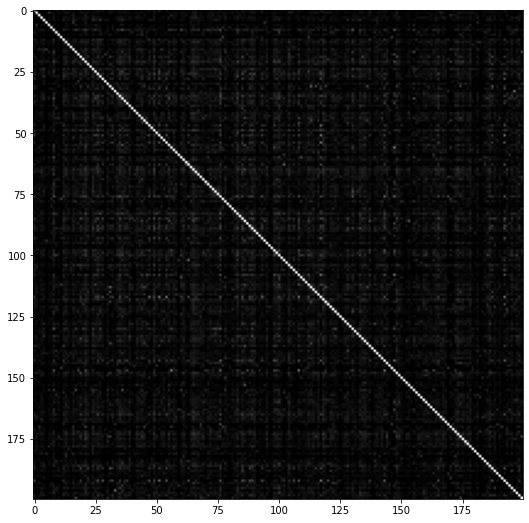

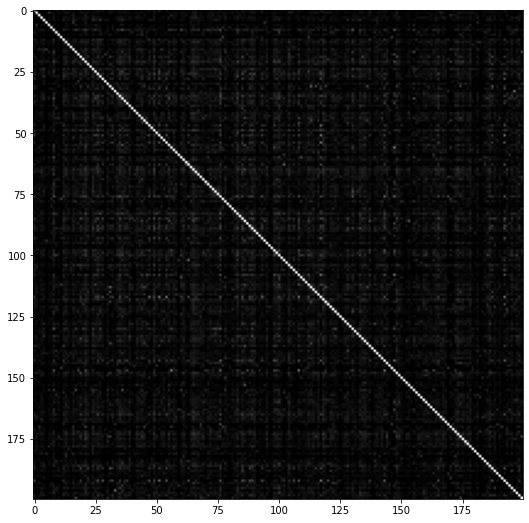

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

tfidf_vectors = tfidf.transform(data.head(200)["tokens"])

plt.figure(figsize=(9, 9))
_ = plt.imshow(cosine_similarity(tfidf_vectors, tfidf_vectors), cmap='gray')

plt.figure(figsize=(9, 9))
_ = plt.imshow(linear_kernel(tfidf_vectors, tfidf_vectors), cmap='gray')